In [1]:
# JobTrend prototype 4
# 
# Sila. January 24, 2020

In [123]:
from google.colab import files
uploaded = files.upload()

Saving init.csv to init.csv


In [115]:
# Upload the JobTrendAds_Transformer_Search.csv file
!ls

JobTrendAds_Transformer_ChangedJobText.csv  sample_data


In [124]:
# Read Jobfile
import pandas as pd

colnames=['Source.Name','ID', 'Date time', 'Details', 'Region', 'Pers.Komp', 'Pers.Komp.Value','Rest'] 
df = pd.read_csv("JobTrendAds_Transformer_Search.csv", usecols = colnames, encoding="utf-8", sep=';', header = 0 )

# The JobTrend file must saved in utf-8 format

In [125]:
df.rename(columns = {'Rest':'JobAdText'}, inplace = True)
df.rename(columns = {'Pers.Komp':'PersonligeKompetencer'}, inplace = True)
# show the data
print ( df .describe( include = 'all' ))
#the describe is a great way to get an overview of the data
#print ( df .values)

              Source.Name            ID         Date time             Details  \
count                 296  2.960000e+02               296                 296   
unique                296           NaN               289                 242   
top     00031-1805634.txt           NaN  21-02-2020 22:37  Multimediedesigner   
freq                    1           NaN                 2                   8   
mean                  NaN  1.053727e+06               NaN                 NaN   
std                   NaN  5.156326e+05               NaN                 NaN   
min                   NaN  7.153000e+03               NaN                 NaN   
25%                   NaN  6.856040e+05               NaN                 NaN   
50%                   NaN  1.080747e+06               NaN                 NaN   
75%                   NaN  1.446393e+06               NaN                 NaN   
max                   NaN  1.960349e+06               NaN                 NaN   

                    Region 

In [126]:
df.drop('Source.Name' , axis = 1 , inplace = True )
df.drop('Date time' , axis = 1 , inplace = True )
df.drop('Details' , axis = 1 , inplace = True )
df.drop('Region' , axis = 1 , inplace = True )

In [127]:
# Replace No-value with zero on Pers.Komp column
df["PersonligeKompetencer"] = df["PersonligeKompetencer"].fillna(0)

In [128]:
df['JobAdText'] = df['JobAdText'].apply(str)

for column in df.columns[3:]:
    print(df[column])

0                                                    ...
1                                                    ...
2                     ...eller  |                    ...
3                                                    ...
4                     ...eller  |                    ...
                             ...                        
291                   ...eller  |                    ...
292                                              Stud...
293                    Praktikant i Multimedia design...
294              Webmaster til vores nye websiteVil d...
295                   ...eller  |                    ...
Name: JobAdText, Length: 296, dtype: object


In [111]:
# Could find sentences with regular expressions, SpaCy etc.
# (But) Using nltk here.

In [81]:
from nltk import tokenize

In [82]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [83]:
nb_personal_qualifications = 0

# For start, only look at 1 row
for row in df.head(1).itertuples():
    AdText = row.JobAdText

    Sentences = tokenize.sent_tokenize(AdText)
    '''doc = nlp(AdText)
    Sentences = []
    for sent in doc.sents:
       Sentences.append(sent.text)'''
    
    # ToDo - This must read from Excel file
    nb_personal_qualifications = int(row[2]) # Pers.Komp

In [84]:
print(nb_personal_qualifications) #print(Sentences)

1


In [85]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
from sentence_transformers import SentenceTransformer, util

In [87]:
# https://huggingface.co/sentence-transformers/multi-qa-MiniLM-L6-cos-v1

model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [88]:
import numpy as np

In [89]:
def FindkHighestkNumbers(scores, k):
    return (-scores).argsort()[:k]

In [90]:
def PresentAsSubstring(CurrentSentences, LookupSentence, Verbose):
    foundmatch = False
    for value in CurrentSentences:
       # Find
       if (value.find(LookupSentence) != -1):
           if (Verbose==True):
              print(value, " Contains ", LookupSentence)
           foundmatch = True

    return foundmatch 

In [91]:
def QualificationPresentAsSubstring(CurrentSentences, qualifications, Verbose):
  FoundQualificationAsSubstring = False
  for i in range(len(qualifications)):
     Lookup_Sentence= qualifications[i]
     if (PresentAsSubstring(CurrentSentences, Lookup_Sentence, Verbose) == True):
        FoundQualificationAsSubstring = True
     
  return FoundQualificationAsSubstring      

In [92]:
def FindMostSimilarSentence(Corpus, LookupSentence):
    # encode corpus to get corpus embeddings
    corpus_embeddings = model.encode(Corpus, convert_to_tensor=True)
    # encode sentence to get sentence embeddings
    sentence_embedding = model.encode(LookupSentence, convert_to_tensor=True)# top_k results to return
    top_k=1# compute similarity scores of the sentence with the corpus
    cos_scores = util.pytorch_cos_sim(sentence_embedding, corpus_embeddings)[0]# Sort the results in decreasing order and get the first top_k
    # top_results = np.argpartition(-cos_scores, range(top_k))[0:top_k] #CPU
    top_results= FindkHighestkNumbers(cos_scores,top_k) #GPU

    # print("\n", "Sentence:", LookupSentence, "\n")
    # print("Top", top_k, "most similar sentences in corpus:")
    best_result=0
    for idx in top_results[0:top_k]:
       #print(Corpus[idx], "(Score: %.4f)" % (cos_scores[idx]))
       best_result= cos_scores[idx] 

    return Corpus[top_results[0]], best_result

In [93]:
target_sentence = "Har gode kommunikationsevner"

In [94]:
# Test
# FindMostSimilarSentences(Sentences, target_sentence) 
FindMostSimilarSentence(Sentences, target_sentence) 

('Du giver også virksomheden mulighed for at kontakte dig, hvis de i fremtiden har et job, der matcher dine kompetencer.',
 tensor(0.4745, device='cuda:0'))

In [95]:
personal_qualifications=['Har gode kommunikationsevner',
'Kan arbejde selvmotiverende',
'Du tager ansvar for dine projekter og følger altid dine opgaver til dørs',
'Vi forventer, at du som person er selvledende, kreativ, fleksibel og indstillet på at arbejde i et travlt miljø.',
'Du er nysgerrig, kritisk og løsningsorienteret - også når det bliver komplekst',
'Du har drive, og passion for kvalitet',
'Du er god til at tænke ud af boksen, er ambitiøst og kreativt tænkende',
'er engageret, har god energi og er en god kollega',
'Som person er du først og fremmest kreativ og du er god til at finde på nye løsninger',
'Du er ansvarsfuld, selvstændig og har mod på at udvikle dig'
'Være initiativrig og opsøgende',
'Ivrig efter af lære Som person forestiller vi os, at du er engageret, kreativ og nysgerrig',
'Du er god til at skabe relationer på tværs',
'er selvstændig og grundig',
'Du har flair for content',
'Du er frisk, nede på jorden og klar på en god snak med dine kollegaer',
'Du trives med rutineprægede opgaver, og bidrager med masser af godt humør',
'Er optimist og ser muligheder fremfor begrænsninger',
'Vi forestiller os, at du som person er kreativ, visuel og har god sans for detaljen.Vi forestiller os, at du som person er kreativ, visuel og har god sans for detaljen',
'Som menneske er du udadvendt, opsøgende og pædagogisk',
'Er kvalitetsbevidst og sætter en stolthed i at udføre et godt stykke arbejde',
'Er detaljeorienteret og har en struktureret tilgang til dine arbejdsopgaver',
'Er god til at tale med mennesker og sætte sig ind i deres behov',
'Du er detaljeorienteret til mindste detalje og stortrives med en bred kontaktflade',
'Du er struktureret og har høj selvdisciplin',
'Du udviser en høj grad af uafhængighed, er proaktiv og selvstartende',
'Vi søger en person, der er detaljeorienteret og analytisk stærk',
'Du trives med at være opsøgende Du kan arbejde både selvstændigt og som del af et mindre team',
'er ansvarlig, struktureret og målorienteret samt serviceminded, positiv og imødekommende',
'Kreativ, nysgerrig, initiativrig og ikke bange for at spørge. Struktureret og detaljeorienteret',
'At du har et godt drive, kan arbejde selvstændigt, struktureret og tage ansvar',
'Du er god til at styre din tid og trives med at have mange bolde i luften']

In [96]:
def FindPersonalQualificationsVerbose(Corpus):
  for i in range(len(personal_qualifications)):
     Lookup_Sentence=personal_qualifications[i]
     bestmatch, bestmatchvalue = FindMostSimilarSentence(Sentences, Lookup_Sentence)
     print(Lookup_Sentence)
     print(bestmatch, bestmatchvalue)

In [97]:
# Find best matches, above threshold

In [98]:
def FindQualifications(Corpus, qualifications):
  highvalue=0
  highestmatchedsentence=""
  highestlookup=""
  for i in range(len(qualifications)):
     Lookup_Sentence= qualifications[i]
     bestmatch, bestmatchvalue = FindMostSimilarSentence(Corpus, Lookup_Sentence)

     if bestmatchvalue.cpu().detach().numpy()>highvalue: 
        highvalue = bestmatchvalue.cpu().detach().numpy() 
        highestmatchedsentence = bestmatch
        highestlookup=Lookup_Sentence
  return highestmatchedsentence,highestlookup,highvalue

In [99]:
def FindTopQualification(Corpus, qualifications, typeofqualification, UseVerbose):
    highestmatchedsentence,highestlookup,highvalue = FindQualifications(Corpus, qualifications)

    if UseVerbose == True:
       print("\n")
       print(typeofqualification,"qualifications in JobAds.")
    
    print("Match :", highestmatchedsentence)
    print('Lookup: ', highestlookup)
    print('Match: ', "(Score: %.4f)" % (highvalue))

    return highvalue

In [100]:
FindTopQualification(Sentences, personal_qualifications, "Personal", True)



Personal qualifications in JobAds.
Match : Vi forventer, at du:  Har en relevant professionsbachelor i e-handel, er multimediedesigner, markedsføringsøkonom eller grafisk uddannet Har erfaring i brug af InDesign, Illustrator og Photoshop Har gode kommunikationsevner Kan arbejde selvmotiverende Er fejlfri på skriftlig dansk og engelsk Erfaring med SEO.
Lookup:  Vi forventer, at du som person er selvledende, kreativ, fleksibel og indstillet på at arbejde i et travlt miljø.
Match:  (Score: 0.6143)


array(0.6143223, dtype=float32)

In [101]:
def FindTopQualificationsForDataSet(threshold):
   ad_number=1
   # Run Through entire dataset 
   for row in df.head(100).itertuples():
       AdText = row.JobAdText

       Sentences = tokenize.sent_tokenize(AdText)

       # This must be read from Excel file
       nb_personal_qualifications = int(row.PersonligeKompetencer)
       y_real.append(row.PersonligeKompetencer)

       ad_number += 1
       print("Ad number: ", ad_number)
        
       matchingvalue = 0
       MatchAsSubString = QualificationPresentAsSubstring(Sentences, personal_qualifications, True)
       if (MatchAsSubString== True):
           print("Exact match. Assume matching value equal to 1")
           matchingvalue = 1 
           y_predicted.append(1)
       else:
           matchingvalue = FindTopQualification(Sentences, personal_qualifications, "Personal", False)
           if (matchingvalue>threshold):
              y_predicted.append(1)
           else:
              y_predicted.append(0)

       if (nb_personal_qualifications==1):
          if (matchingvalue<threshold):
              print("WRONG")
       else:
          if (matchingvalue>threshold):
              print("WRONG")

In [129]:
y_real=[]
y_predicted=[]
FindTopQualificationsForDataSet(0.7)

Ad number:  2
Vi forventer, at du:  Har en relevant professionsbachelor i e-handel, er multimediedesigner, markedsføringsøkonom eller grafisk uddannet Har erfaring i brug af InDesign, Illustrator og Photoshop Har gode kommunikationsevner Kan arbejde selvmotiverende Er fejlfri på skriftlig dansk og engelsk Erfaring med SEO.  Contains  Har gode kommunikationsevner
Vi forventer, at du:  Har en relevant professionsbachelor i e-handel, er multimediedesigner, markedsføringsøkonom eller grafisk uddannet Har erfaring i brug af InDesign, Illustrator og Photoshop Har gode kommunikationsevner Kan arbejde selvmotiverende Er fejlfri på skriftlig dansk og engelsk Erfaring med SEO.  Contains  Kan arbejde selvmotiverende
Exact match. Assume matching value equal to 1
Ad number:  3
Match : Hvis du er interesseret i stillingen, bedes du sende en personlig ansøgning indeholdende:  • Dit navn, alder, telefonnummer og email-adresse • Beskrivelse af din motivation og dine kompetencer for at være støtteperson

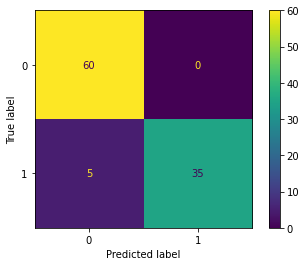

In [122]:
# For the JobTrendAds_Transformer_Search.csc file we get:
cm = confusion_matrix(y_real, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [70]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

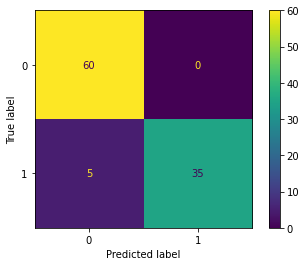

In [130]:
# For the JobTrendAds_Transformer_ChangedJobText file we get exact similar.
cm = confusion_matrix(y_real, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [131]:
''' There are some misclassifications in the model 
E.g. with threshold 0.7:
Ad 53 gets misclassified.
Match : Og trives du med både at arbejde selvstændigt og samtidigt lære fra dig?
Lookup:  Du trives med at være opsøgende Du kan arbejde både selvstændigt og som del af et mindre team
Match:  (Score: 0.6371)


But it is a robust model: 
E.g. 
We get the same results when the ad text is changed in a number of ways.
See the file JobTrendAds_Transformer_Search.csv with changes in JobTrendAds_Transformer_ChangedJobText.csv:

5
Ad number:  5
Du tager ansvar for dine projekter og følger altid dine opgaver til dørs.  Contains  Du tager ansvar for dine projekter og følger altid dine opgaver til dørs
Exact match. Assume matching value equal to 1

Rettet til.
Ad number:  5
Match : Du er ansvarlig og gør dine opgaver færdige.
Lookup:  Du tager ansvar for dine projekter og følger altid dine opgaver til dørs
Match:  (Score: 0.7079)

48
Du er struktureret og har høj selvdisciplin.  Contains  Du er struktureret og har høj selvdisciplin
Du udviser en høj grad af uafhængighed, er proaktiv og selvstartende.  Contains  Du udviser en høj grad af uafhængighed, er proaktiv og selvstartende
Vi søger en person, der er detaljeorienteret og analytisk stærk.  Contains  Vi søger en person, der er detaljeorienteret og analytisk stærk
Exact match. Assume matching value equal to 1

Flere exact matches. Så finder resultat uden at se på rettelsen.

62
Oprindelig:
Exact match på.
Du er god til at styre din tid og trives med at have mange bolde i luften

Nu, sætningen er vendt om.
Match : Du har mange bolde i luften og er god til at få noget ud af tiden.
Lookup:  Du er god til at styre din tid og trives med at have mange bolde i luften
Match:  (Score: 0.7758)


81
Ad number:  81
Match : Vi forventer, at du er nysgerrig og selv undersøger mulige løsninger på grafiske og tekniske udfordringer.
Lookup:  Vi forventer, at du som person er selvledende, kreativ, fleksibel og indstillet på at arbejde i et travlt miljø.
Match:  (Score: 0.7296)

Med relativ lav threshold, flere forskellige kandidat sætninger accepteret.
Ad number:  81
Match : Du er fleksibel, arbejder selvstændigt  og er indstillet på at arbejde i et travlt miljø.
Lookup:  Vi forventer, at du som person er selvledende, kreativ, fleksibel og indstillet på at arbejde i et travlt miljø.
Match:  (Score: 0.7471)

97.
Ad number:  97
Vi forventer, at du som person er selvledende, kreativ, fleksibel og indstillet på at arbejde i et travlt miljø. 
 Contains  Vi forventer, at du som person er selvledende, kreativ, fleksibel og indstillet på at arbejde i et travlt miljø.
Exact match. Assume matching value equal to 1

Mindre omskivninger af sætningen accepteres stadig.
Match : Du er som person selvstændigt og kreativ, at arbejde i et travlt miljø er lige dig.
Lookup:  Vi forventer, at du som person er selvledende, kreativ, fleksibel og indstillet på at arbejde i et travlt miljø.
Match:  (Score: 0.7213)'''

' There are some misclassifications in the model \nE.g. with threshold 0.7:\nAd 53 gets misclassified.\nMatch : Og trives du med både at arbejde selvstændigt og samtidigt lære fra dig?\nLookup:  Du trives med at være opsøgende Du kan arbejde både selvstændigt og som del af et mindre team\nMatch:  (Score: 0.6371)\n\n\nBut it is a robust model: \nE.g. \nWe get the same results when the ad text is changed in a number of ways.\nSee the file JobTrendAds_Transformer_Search.csv with changes in JobTrendAds_Transformer_ChangedJobText.csv:\n\n5\nAd number:  5\nDu tager ansvar for dine projekter og følger altid dine opgaver til dørs.  Contains  Du tager ansvar for dine projekter og følger altid dine opgaver til dørs\nExact match. Assume matching value equal to 1\n\nRettet til.\nAd number:  5\nMatch : Du er ansvarlig og gør dine opgaver færdige.\nLookup:  Du tager ansvar for dine projekter og følger altid dine opgaver til dørs\nMatch:  (Score: 0.7079)\n\n48\nDu er struktureret og har høj selvdisci